In [2]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [3]:
import cv2
from PIL import Image

In [4]:
import sys
sys.path.append("C:/git/computer-vision-control/")

# Read images

In [5]:
from glob import glob

In [6]:
hand_files = glob("C:/git/computer-vision-control/images/hand_detection/hand/*.png")
not_hand_files = glob("C:/git/computer-vision-control/images/hand_detection/not_hand/*.png")

In [7]:
len(hand_files)

113

In [8]:
len(not_hand_files)

125

# Camera Image

## Preprocessing

In [9]:
from vision_control.camera import *

In [10]:
img = CameraImage(file_path=hand_files[0])

In [11]:
img.preprocess()

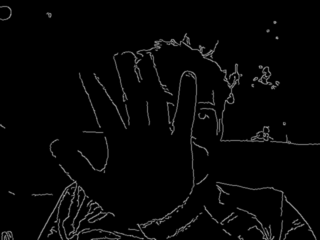

In [12]:
img

## Building the dataset

In [13]:
hand_img = [CameraImage(file_path = file_path,tag = 1) for file_path in hand_files]
not_hand_img = [CameraImage(file_path = file_path,tag = 0) for file_path in not_hand_files]
all_img = hand_img + not_hand_img

In [14]:
images = CameraImages(camera_images=all_img)

In [15]:
images.preprocess()

Preprocessing images: 100%|█████████████████| 238/238 [00:00<00:00, 400.67it/s]


In [16]:
X = images.build_X()

In [17]:
X.shape

(238, 76800)

In [18]:
X = np.divide(X,255)

In [19]:
y = images.build_y()

In [20]:
y.shape

(238, 1)

# Train a simple model

In [21]:
# Keras
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import model_from_json

Using TensorFlow backend.


In [22]:
X.shape[1]

76800

In [33]:
model = Sequential()
model.add(Dense(256,input_dim = X.shape[1],activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [34]:
model.fit(X,y,validation_split=0.1,epochs=5,verbose = 2)

Train on 214 samples, validate on 24 samples
Epoch 1/5
4s - loss: 0.3115 - acc: 0.8364 - val_loss: 0.2115 - val_acc: 0.9583
Epoch 2/5
3s - loss: 0.0182 - acc: 0.9907 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 3/5
3s - loss: 0.0081 - acc: 0.9907 - val_loss: 0.5405 - val_acc: 0.7500
Epoch 4/5
3s - loss: 0.0087 - acc: 0.9953 - val_loss: 0.0174 - val_acc: 1.0000
Epoch 5/5
3s - loss: 3.5516e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000


# Live test

In [51]:
test = CameraImage(capture = True)

In [52]:
test.preprocess()

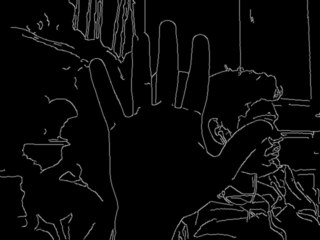

In [53]:
test

In [54]:
test.predict(model)

5.4573275e-07

In [55]:
test = CameraImage(file_path=hand_files[5])

In [57]:
test.preprocess()

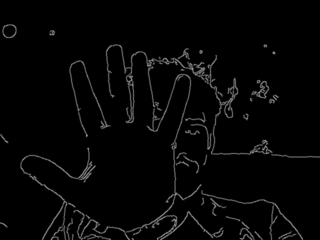

In [58]:
test